In [14]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.result.mitigation.utils import expval_with_stddev, str2diag, counts_probability_vector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor

In [15]:
# Run only once to save the account
#IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186')

In [16]:
"""
provider = IBMProvider()
provider.active_account()
qpu = provider.get_backend()
"""

'\nprovider = IBMProvider()\nprovider.active_account()\nqpu = provider.get_backend()\n'

In [17]:
# Define a backend
backend = AerSimulator.from_backend(FakePerth())

MITIGATION EXPERIMENT SETUP

In [18]:
# Set up the mitigation experiment
qubits = [0]
exp = CorrelatedReadoutError(qubits) 

# Print mitigation experiment circuits
for c in exp.circuits():
    print(c)

         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


MZI EXPERIMENT SETUP

In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.result import marginal_counts

In [20]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R') 
phi_S = Parameter('phi_S')

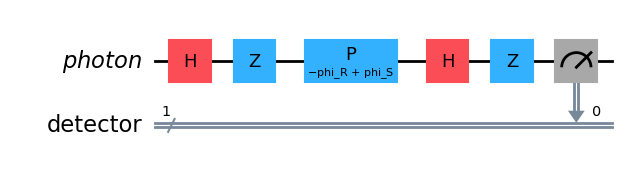

In [21]:
# Create a quantum register named "photon" and a classical bit
qr_photon = QuantumRegister(1, 'photon')
cr = ClassicalRegister(1, 'detector')

# Create a circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(qr_photon, cr)

# 1st BS; creates a superposition and a phase shift by π
qc.h(0)
qc.z(0)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.p(phi_S-phi_R,0)

# 2nd BS and a phase shift by π
qc.h(0)
qc.z(0)

# Measurement on qubit 0 (photon), projection on cbit 0 (detector)
qc.measure(0,0)

# Draw the circuit
qc.draw('mpl')

In [22]:
# Transpile the circuit
qc_trans = transpile(qc, backend)

RUN EXPERIMENTS

In [64]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [106]:
# Assign phase shift params from 0 to 2π, construct a list of circuits
bound_qc = []
for i in range(33):
    param_values = {phi_S: (pi/16)*i, phi_R: 0}
    bound_qc.append(qc_trans.assign_parameters(param_values))

# Define empty arrays that will store results for the experiments
mitigators = []
confusion_matrices = []
inv_confusion_matrices = []

# Runs the mitigation exp, saves the mitigator object, confusion matrix and inv confusion matrix 
def run_mitigation_exp():
    result = exp.run(backend, shots=shots).block_for_results()
    mitigator = result.analysis_results("Correlated Readout Mitigator").value
    mitigators.append(mitigator)
    confusion_matrices.append(mitigator.assignment_matrix())
    inv_confusion_matrices.append(mitigator.mitigation_matrix())

# Run the experiments
run_mitigation_exp()
job = backend.run(bound_qc, shots=shots)
unmitigated_counts = job.result().get_counts()
run_mitigation_exp()

POST PROCESSING

In [268]:
# Define empty arrays to store unmitigated probabilities, mitigated probabilities, and mitigated counts
unmitigated_probs = []
mitigated_quasi_probs = []
mitigated_probs = []
mitigated_counts = []

# Takes in a mitigator index (0 for pre-mitigator, 1 for post-mitigator) and performs the least squares method mitigation
def mitigation_method_1(mitigator_index):
    unmitigated_probs.clear()
    mitigated_quasi_probs.clear()
    mitigated_probs.clear()
    mitigated_counts.clear()
    for i in range(33):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigators[mitigator_index].quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})


def mitigation_method_2(mitigator_index):
    unmitigated_probs.clear()
    mitigated_quasi_probs.clear() 
    mitigated_probs.clear() 
    mitigated_counts.clear() 
    for i in range(33):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0'], unmitigated_counts[i]['1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(inv_confusion_matrices[mitigator_index],vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        if mitigated_quasi_count[0] < 0:
            mitigated_quasi_count[0] = 0
        if mitigated_quasi_count[1] < 0:
            mitigated_quasi_count[1] = 0
        total_count = mitigated_quasi_count[0] + mitigated_quasi_count[1]
        # Define dictionaries
        dict_count = {
            '0': mitigated_quasi_count[0].item(),
            '1': mitigated_quasi_count[1].item()
        }
        dict_prob = {
            '0': (mitigated_quasi_count[0]/total_count).item(),
            '1': (mitigated_quasi_count[1]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)    
        

PRINT RESULT

33
Unmitigated Counts: 
{'1': 4072, '0': 4120}
Mitigated Counts: 
{'1': 4091, '0': 4101}

Unmitigated Prob: 
{'1': 0.4970703125, '0': 0.5029296875}
Mitigated Prob: 
{'1': 0.4993487887470695, '0': 0.5006512112529304}


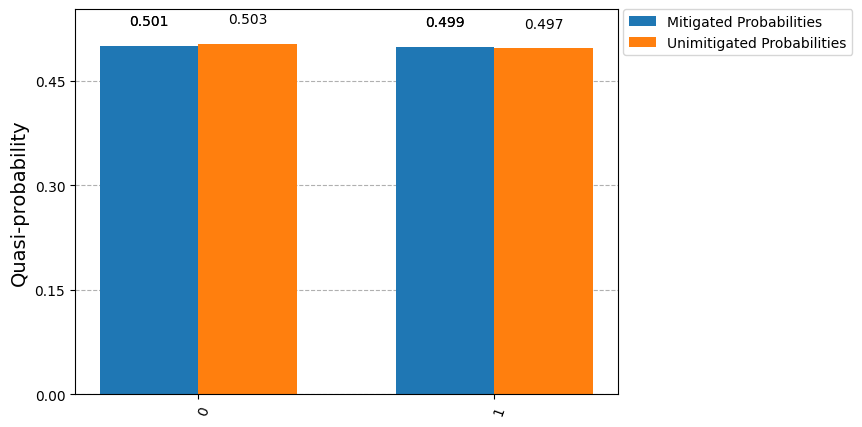

In [275]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
mitigation_method_1(0)


print(len(mitigated_probs))
# Index of a circuit [0~32: 0=0π, 16=π, 32=2π]
i = 8

# Print unmitigated & mitigated counts and plot 
print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)